The goal of this exercise is to determine the risk of a person in developing a Cardiovascular Disease (CVD), such as heart attacks, based on features of their personal lifestyle factors.  
Respondents (participants) were classified as having coronary heart disease (MICHD) if they reported having been tol by a provider they had MICH or if they reported having been told they had a heart attacks or angina.  

It is our job to use the data to build a model able to estimate the likelihood of developing MICHD given a certain clinical and lifestyle situation.  

x_train and x_test : each row corresponds to a person and each column to an health related data  
y_train : Id = correspond to data ID in x_train ; 1 = the person have a MICHD ; -1 = the person does not have a MICHD

In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv

%load_ext autoreload
%autoreload 2


In [95]:
from helpers import load_csv_data


# load data.
data_path = './dataset/'
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

In [119]:
selected_columns = [
    "CVDINFR4", "CVDCRHD4", "CVDSTRK3", "BPHIGH4", "TOLDHI2", "DIABETE3",
    "SMOKE100", "SMOKDAY2", "ALCDAY5", "EXERANY2", "FRUIT1", "VEGETAB1",
    "SEX", "AGE", "INCOME2", "EDUCA", "BMI", "GENHLTH", "PHYSHLTH", 
    "MENTHLTH", "POORHLTH", "CHECKUP1", "BPMEDS", "BLOODCHO", "CHOLCHK", 
    "TOLDHI2", "ASTHMA3", "ASTHNOW", "CHCSCNCR", "CHCOCNCR", "CHCCOPD1",
    "ADDEPEV2", "CHCKIDNY", "EMPLOY1", "WEIGHT2", "HEIGHT3", "DIFFWALK",
    "AVEDRNK2", "FVGGREEN", "EXERHMM1", "PREDIAB1", "QLMENTL2", "QLSTRES2",
    "CVDASPRN", "SCNTMNY1"
]

# Ouvrir le fichier CSV
with open('./dataset/x_train.csv', newline='', encoding='utf-8') as csvfile:
    # Lire le fichier CSV avec le lecteur csv
    columns_name = csvfile.readline().strip().split(',')

# Indices des colonnes à conserver
indices_colonnes = [columns_name.index(col) for col in selected_columns if col in columns_name]
x_train = np.genfromtxt('./dataset/x_train.csv', delimiter=',', skip_header=1, usecols=indices_colonnes, dtype=float)
x_test = np.genfromtxt('./dataset/x_test.csv', delimiter=',', skip_header=1, usecols=indices_colonnes, dtype=float)

In [49]:
from Preprocessing_functions import *
x_train_final_headers, x_train, x_val, y_train, y_val = Preprocess_data(data_path,
                                                                              x_train,  
                                                                              y_train,
                                                                              balance_method="undersample",  
                                                                              low_corr_threshold=0.05, 
                                                                              high_corr_threshold=0.9, 
                                                                              variance_threshold=0.01, 
                                                                              p_value_threshold=0.05, 
                                                                              missing_val_threshold=0.25)


Step 1: Remove Missing Values - Reason: Too many missing values:
Removed 9 features: ['IYEAR', 'NUMMEN', 'CTELNUM1', 'CSTATE', 'CHECKUP1', 'BPHIGH4', 'BPMEDS', 'BLOODCHO', 'CHOLCHK']
All checks passed: The dataset has only binary or continuous features.

Step 2: Variance Thresholding - Reason: Low variance:
Removed 40 features: ['_STATE_7.0_encoded', '_STATE_9.0_encoded', 'FMONTH_2.0_encoded', 'FMONTH_4.0_encoded', 'FMONTH_7.0_encoded', 'FMONTH_9.0_encoded', 'IDATE_7.0_encoded', 'IDATE_9.0_encoded', 'IMONTH_2.0_encoded', 'IMONTH_7.0_encoded', 'IMONTH_9.0_encoded', 'IDAY_7.0_encoded', 'IDAY_9.0_encoded', 'SEQNO_7.0_encoded', 'SEQNO_9.0_encoded', 'STATERES_1.0_encoded', 'STATERES_9.0_encoded', 'CELLFON3_7.0_encoded', 'CELLFON3_9.0_encoded', 'NUMWOMEN_8.0_encoded', 'NUMWOMEN_9.0_encoded', 'CELLFON2_9.0_encoded', 'CADULT_9.0_encoded', 'PVTRESD2_7.0_encoded', 'PVTRESD2_9.0_encoded', 'CCLGHOUS_7.0_encoded', 'CCLGHOUS_9.0_encoded', 'LANDLINE_7.0_encoded', 'LANDLINE_9.0_encoded', 'HHADULT_7.0

## Data Preprocessing ##  

1. Select only the column that might have a correlation to the output (based on personal knowledge or assumption)

2. Standardize the remaining data :  

Normalize each feature in x_train and x_test so that they have a mean of 0 and standard deviation of 1. This is particularly useful for algorithms like logistic regression and gradient descent.

In [120]:
def standardization(data):
    """
    Standardize each column in the dataset  to have a mean of 0 and standard deviation of 1.

    Args:
        data: numpy array of shape (N, D) where N is the number of samples and D is the number of features.

    Returns:
        standardized_data: numpy array of shape (N, D) with standardized columns.
    """
    # Mean and Standard deviation for each column
    mean = np.nanmean(data, axis=0)
    std = np.nanstd(data, axis=0)
    

    standardized_data = (data - mean) / std
    
    return standardized_data

In [121]:
x_train_std = standardization(x_train)
x_test_std = standardization(x_test)

3. Handle Imbalanced Classes :  

f there is a strong imbalance between the MICHD and non-MICHD labels in y_train, consider balancing the classes.

In [122]:
def balance_classes(x_train, y_train):
    """
    Balances x_train and y_train to have an equal number of -1 and 1 labels.
    
    Args:
        x_train: numpy array of shape (N, D), where N is the number of samples and D is the number of features.
        y_train: numpy array of shape (N,), where N is the number of samples and each entry is either 1 or -1.
        
    Returns:
        x_train_balanced: numpy array of balanced samples.
        y_train_balanced: numpy array of balanced labels.
    """
    # Find indices for each class
    indices_class_1 = np.where(y_train == 1)[0]
    indices_class_neg_1 = np.where(y_train == -1)[0]
    
    # Determine the smaller class size
    min_class_size = min(len(indices_class_1), len(indices_class_neg_1))
    
    # Randomly select indices to balance the classes
    balanced_indices_class_1 = np.random.choice(indices_class_1, min_class_size, replace=False)
    balanced_indices_class_neg_1 = np.random.choice(indices_class_neg_1, min_class_size, replace=False)
    
    # Combine indices and shuffle
    balanced_indices = np.concatenate([balanced_indices_class_1, balanced_indices_class_neg_1])
    np.random.shuffle(balanced_indices)
    
    # Filter x_train and y_train based on balanced indices
    x_train_balanced = x_train[balanced_indices]
    y_train_balanced = y_train[balanced_indices]
    
    return x_train_balanced, y_train_balanced

In [123]:
x_train_bal, y_train_bal = balance_classes(x_train_std, y_train)

print(x_train_bal.shape)
print(x_train_std.shape)
print(y_train_bal.shape)
print(y_train.shape)

(46160, 38)
(328135, 38)
(46160,)
(46360,)


In [124]:
def replace_nan_with_zero(x_train):
    """
    Replace NaN values in x_train with 0.

    Args:
        x_train: numpy array of shape (N, D), where N is the number of samples and D is the number of features.

    Returns:
        x_train_clean: numpy array of shape (N, D) with NaN values replaced by 0.
    """
    # Replace NaN with 0
    x_train_clean = np.nan_to_num(x_train, nan=0.0)
    
    
    return x_train_clean
x_train_bal = replace_nan_with_zero(x_train_bal)

## Feature Importance Analysis ##

1. Correlation Analysis : high positive or negative correlation suggests that a feature may be impactful

In [12]:
import seaborn as sns 

def compute_correlations(x_train, y_train):
    """
    Computes the correlation coefficients between each feature in x_train and the target y_train.
    
    Args:
        x_train: numpy array of shape (N, D) where N is the number of samples and D is the number of features.
        y_train: numpy array of shape (N,) where N is the number of samples.
    
    Returns:
        correlations: numpy array of shape (D,) with correlation coefficients for each feature.
    """
    # Initialiser un tableau pour stocker les corrélations
    correlations = []
    
    # Calculer la corrélation pour chaque colonne de x_train avec y_train
    for i in range(x_train.shape[1]):
        feature_column = x_train[:, i]
        
        # Calculer la corrélation en excluant les NaN
        valid_mask = ~np.isnan(feature_column) & ~np.isnan(y_train)
        correlation = np.corrcoef(feature_column[valid_mask], y_train[valid_mask])[0, 1]
        
        # Ajouter la corrélation calculée à la liste
        correlations.append(correlation)
        
    return np.array(correlations)

def plot_correlation_heatmap(x_train, y_train, feature_names):
    """
    Plots a heatmap of the correlation coefficients between features in x_train and y_train.
    
    Args:
        x_train: numpy array of shape (N, D) where N is the number of samples and D is the number of features.
        y_train: numpy array of shape (N,) where N is the number of samples.
        feature_names: list of strings, names of the features in x_train.
    """
    # Calculer la matrice de corrélation complète, y compris la cible
    data_with_y = np.column_stack((x_train, y_train))
    corr_matrix = np.corrcoef(data_with_y, rowvar=False)
    print(corr_matrix)
    # Créer une heatmap de la matrice de corrélation avec la palette "Spectral"
    plt.figure(figsize=(15, 8))
    sns.heatmap(corr_matrix, cmap="Spectral", xticklabels=feature_names + ["MICHD"], yticklabels=feature_names + ["MICHD"], cbar=True,)
    plt.title("Matrice de corrélation des caractéristiques et de MICHD")
    plt.show()

[[ 1.          0.07547361  0.03748347 ...  0.01124091  0.02232437
  -0.1196821 ]
 [ 0.07547361  1.          0.20782026 ...  0.05295755  0.00502611
  -0.35461172]
 [ 0.03748347  0.20782026  1.         ...  0.02486701  0.00961401
  -0.1790809 ]
 ...
 [ 0.01124091  0.05295755  0.02486701 ...  1.         -0.00580971
  -0.06849735]
 [ 0.02232437  0.00502611  0.00961401 ... -0.00580971  1.
  -0.0250998 ]
 [-0.1196821  -0.35461172 -0.1790809  ... -0.06849735 -0.0250998
   1.        ]]


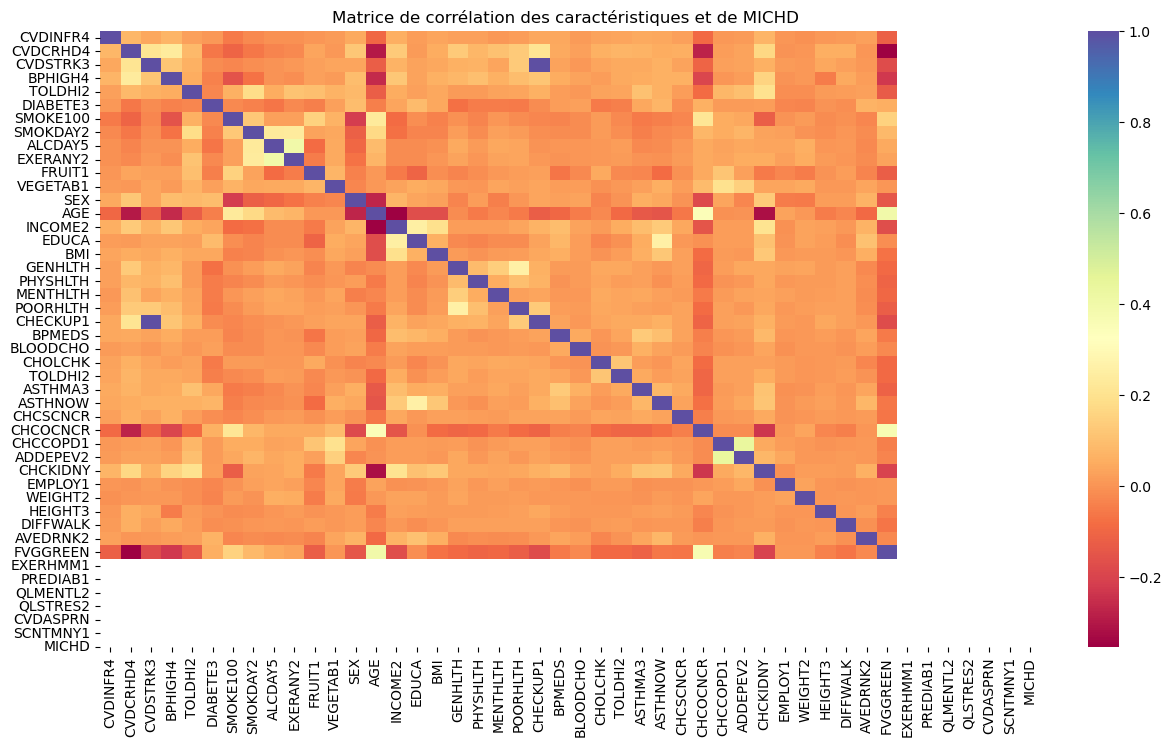

[-0.1196821  -0.35461172 -0.1790809  -0.22929636 -0.13262377  0.05557959
  0.15001902  0.07974382  0.0461219   0.03060778 -0.12351622  0.00407352
 -0.14513972  0.39841434 -0.17156632 -0.01378312 -0.07410195 -0.09508003
 -0.10982095 -0.10055792 -0.12289935 -0.1790809  -0.05485468 -0.02368499
 -0.09078229 -0.0914802  -0.11501183 -0.06218043 -0.06480178  0.36973054
 -0.04474285 -0.0333577  -0.20345721  0.00701869  0.00908934 -0.04160161
 -0.06849735 -0.0250998 ]


In [13]:
corr_matrix = compute_correlations(x_train_bal, y_train_bal)

plot_correlation_heatmap(x_train_bal, y_train_bal, selected_columns)
print(corr_matrix)

2. Feature Selection techniques :  

using statistical tests or regularized logistic regression (Ridge Regression)

## Model Training ##  

In order to have scores and to know which method is the best : split the training dataset between training and validation and get the scores results for the validation set.  
The final score result can be compute when putting the y predicted from the x_test on the internet page for ranking. 
Scores selected should be : F1_score, accuracy, loss

In [125]:
# Mélanger les indices de manière aléatoire
indices = np.arange(x_train_bal.shape[0])
np.random.shuffle(indices)

# Calculer le point de séparation pour un ratio 80-20
split_index = int(0.8 * x_train_bal.shape[0])

# Séparer les indices pour l'entraînement et la validation
train_indices = indices[:split_index]
val_indices = indices[split_index:]

# Créer les ensembles d'entraînement et de validation
x_train, y_train = x_train_bal[train_indices], y_train_bal[train_indices]
x_val, y_val = x_train_bal[val_indices], y_train_bal[val_indices]

In [126]:
from implementationsphi import sigmoid

def f1_score (y_true, y_pred) :
    y_pred_bin = (y_pred >= 0.5).astype(int)
    
    # Calcul des True Positives, False Positives et False Negatives
    TP = np.sum((y_true == 1) & (y_pred_bin == 1))
    FP = np.sum((y_true == 0) & (y_pred_bin == 1))
    FN = np.sum((y_true == 1) & (y_pred_bin == 0))
    
    # Calcul de la précision et du rappel
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Calcul du F1 score
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

1. **Gradient Descent method**   

The methods seem to diverge if gamma is above 0.5. Try several number between 0 and 0.5 and keep the best results. .

In [127]:
from implementationsphi import mean_squares_error_gd, sigmoid

gammas = [1e-2, 1e-1, 2e-1, 3e-1]
max_iters_list = [50, 100, 150, 200]

#Best Hyperparameter variables
best_f1 = 0
best_gamma = None
best_max_iters = None
best_loss = None
best_accuracy = None

#Change binary values (-1, 1) of y to binary values (0, 1) for classification
y_train_bin = np.where(y_train == -1, 0, 1)
y_val_bin = np.where(y_val == -1, 0, 1)

training_losses = np.zeros([len(max_iters_list), len(gammas)])

validation_f1 = np.zeros([len(max_iters_list), len(gammas)])
validation_losses = np.zeros([len(max_iters_list), len(gammas)])
validation_accuracies = np.zeros((len(max_iters_list), len(gammas)))

#Test on the different gammas and iterations
for gamma in gammas:
    for max_iters in max_iters_list:
        #Weights initialization
        initial_w = np.zeros((x_train.shape[1]))   

        #Train the model on current hyperparameters
        w, train_loss = mean_squares_error_gd(y_train_bin, x_train, initial_w, max_iters, gamma)

        #Prediction on the validation set
        y_val_pred = np.dot(x_val, w)
        y_val_pred_prob = sigmoid(y_val_pred)
        y_val_pred = (y_val_pred_prob >= 0.5).astype(int)  # Conversion to 0 or 1
        
        #F1_score and accuracy calculation on validation set
        f1 = f1_score(y_val_bin, y_val_pred)
    
        accuracy = np.mean(y_val_pred == y_val_bin)
        val_loss = np.mean((y_val_pred - y_val_bin) ** 2)  # MSE for validation set

        training_losses[max_iters_list.index(max_iters), gammas.index(gamma)] = train_loss
        
        validation_f1 [max_iters_list.index(max_iters), gammas.index(gamma)] = f1
        validation_losses[max_iters_list.index(max_iters), gammas.index(gamma)] = val_loss
        validation_accuracies[max_iters_list.index(max_iters), gammas.index(gamma)] = accuracy
        
        #Update the best hyperparameter if the F1_score is higher 
        if f1 > best_f1:
            best_f1 = f1
            best_gamma = gamma
            best_max_iters = max_iters
            best_loss = val_loss
            best_accuracy = accuracy
            
            
        
print("Best gamma :", best_gamma)
print("Best iteration :", best_max_iters)
print("Best F1 score on validation set :", best_f1)
print("Best accuracy on validation set:", best_accuracy)
print("Best loss on validation :", best_loss)

Best gamma : 0.1
Best iteration : 50
Best F1 score on validation set : 0.48860224619148224
Best accuracy on validation set: 0.5018414211438474
Best loss on validation : 0.4981585788561525


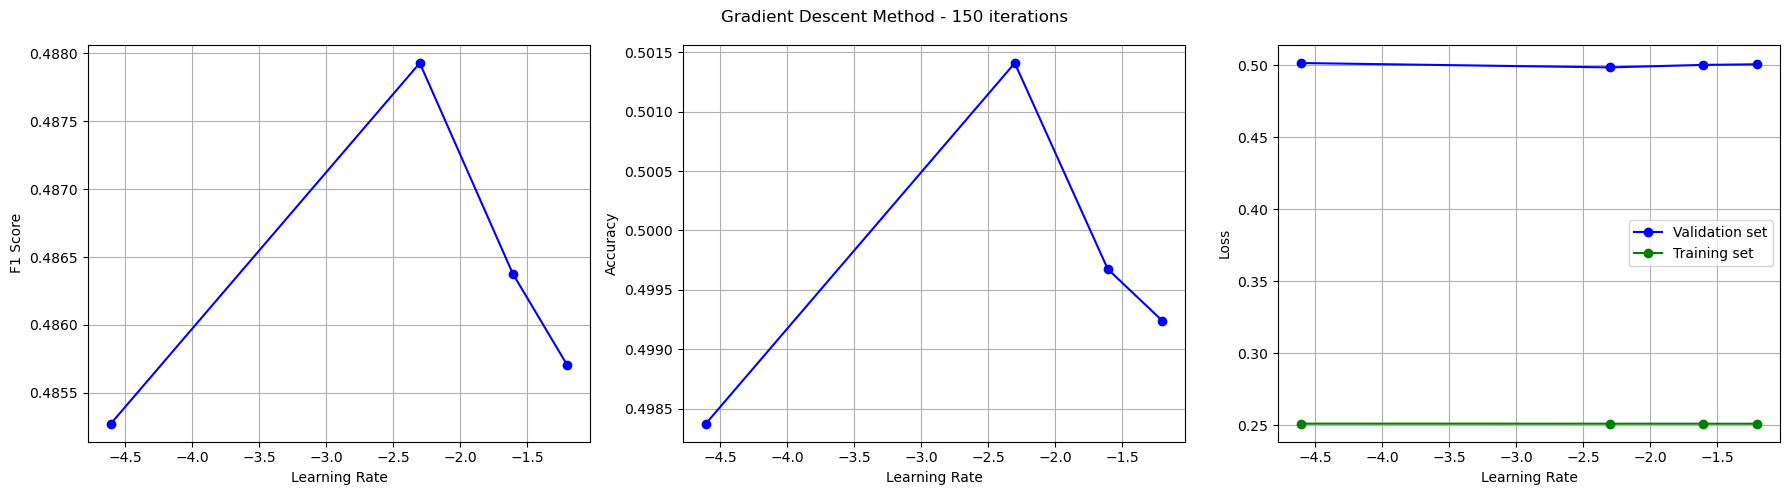

In [128]:
import matplotlib.pyplot as plt

# Get the index for 150 iterations in max_iters_list
iter_index = max_iters_list.index(150)

# Set up the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot F1 Score
axes[0].plot(np.log(gammas), validation_f1[iter_index, :], marker='o', color='b')
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("F1 Score")
axes[0].grid(True)

# Plot Accuracy
axes[1].plot(np.log(gammas), validation_accuracies[iter_index, :], marker='o', color='b')
axes[1].set_xlabel("Learning Rate")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)

# Plot Loss
axes[2].plot(np.log(gammas),  validation_losses[iter_index, :], marker='o', color='b', label='Validation set')
axes[2].plot(np.log(gammas),  training_losses[iter_index, :], marker='o', color='g', label ='Training set')
axes[2].set_xlabel("Learning Rate")
axes[2].set_ylabel("Loss")
axes[2].grid(True)
axes[2].legend()

# Adjust layout
fig.suptitle('Gradient Descent Method - 150 iterations')
plt.tight_layout()
plt.show()


**Overfitting** : if the training loss keep decreasing but the validation loss start to increase, overfitting is occuring.

 2. **Stochastic Gradient Descent method**  

The method seems to do not work for gamma above 0.1. So we selected different gamma between 0.00001 and 0.01. Indeed, the learning rate for the SGD is usually smaller than for GD because, because the weights are update for each point of the dataset and so it allow to reduce the variations of the weight and converge more rapidly.

In [129]:
from implementationsphi import mean_squared_error_sgd

gammas = [1e-10, 1e-5, 1e-2]
max_iters = 100

#Best Hyperparameter variables
best_f1 = 0
best_gamma = None
best_max_iters = None
best_loss = None

y_train_bin = np.where(y_train == -1, 0, 1)

training_losses = []

validation_f1 = []
validation_losses = []
validation_accuracies = []

#Test on the different gammas and iterations
for gamma in gammas:
    
    #Weights initialization
    initial_w = np.zeros((x_train.shape[1]))   

    #Train the model on current hyperparameters
    w, train_loss = mean_squared_error_sgd(y_train_bin, x_train, initial_w, max_iters, gamma)

    #Prediction on the validation set
    y_val_pred = np.dot(x_val, w)  
    y_val_prob = sigmoid(y_val_pred)
    y_val_pred = (y_val_pred_prob >= 0.5).astype(int)  # Conversion to 0 or 1
    
    #F1_score and accuracy calculation on validation set
    f1 = f1_score(y_val_bin, y_val_pred)

    accuracy = np.mean(y_val_pred == y_val_bin)
    val_loss = np.mean((y_val_pred - y_val_bin) ** 2)  # MSE for validation set

    training_losses.append(train_loss)
        
    validation_f1.append(f1)
    validation_losses.append(val_loss)
    validation_accuracies.append(accuracy)
        
    #Update the best hyperparameter if the F1_score is higher 
    if f1 > best_f1:
        best_f1 = f1
        best_gamma = gamma
        best_max_iters = max_iters
        best_loss = val_loss
        best_accuracy = accuracy
            
            
print("Best gamma :", best_gamma)
print("Best iteration :", best_max_iters)
print("Best F1 score on validation set :", best_f1)
print("Best accuracy on validation set:", best_accuracy)
print("Best loss on validation :", best_loss)

Convergence reached at iteration 1 with tolerance 1e-06 and gamma 1e-10
Convergence reached at iteration 12 with tolerance 1e-06 and gamma 1e-05
Best gamma : 1e-10
Best iteration : 100
Best F1 score on validation set : 0.48570475025030596
Best accuracy on validation set: 0.49924176776429807
Best loss on validation : 0.5007582322357019


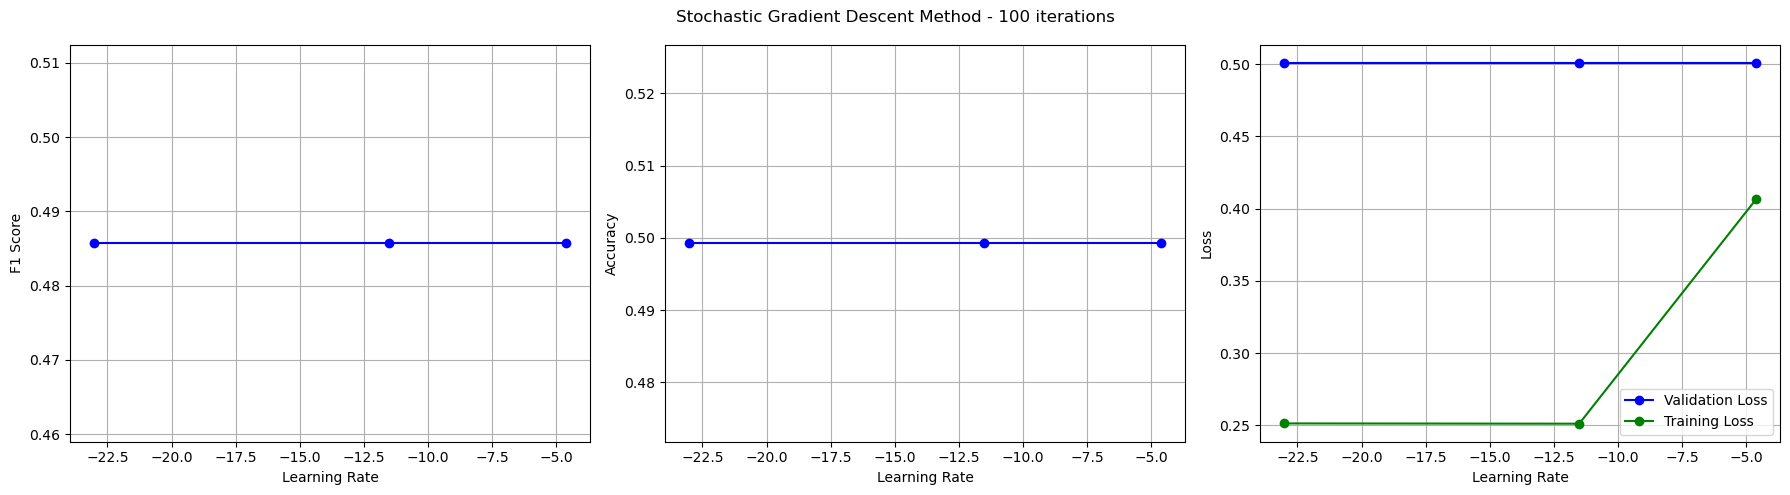

In [130]:
# Set up the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot F1 Score
axes[0].plot(np.log(gammas), validation_f1, marker='o', color='b')
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("F1 Score")
axes[0].grid(True)

# Plot Accuracy
axes[1].plot(np.log(gammas), validation_accuracies, marker='o', color='b')
axes[1].set_xlabel("Learning Rate")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)

# Plot Loss
axes[2].plot(np.log(gammas),  validation_losses, marker='o', color='b', label='Validation Loss')
axes[2].plot(np.log(gammas),  training_losses, marker='o', color='g', label='Training Loss')
axes[2].set_xlabel("Learning Rate")
axes[2].set_ylabel("Loss")
axes[2].grid(True)
axes[2].legend()


# Adjust layout
fig.suptitle('Stochastic Gradient Descent Method - 100 iterations')
plt.tight_layout()
plt.show()


After finding the best parameter for gamma (gamma = 0.01), it is possible to use the method on way more iterations to see if we get better results and if the method converge to a result.

In [132]:
from implementationsphi import mean_squared_error_sgd
# Initialize parameters
initial_w = np.zeros((x_train.shape[1]))  
max_iters = 500     #increase iteration from 100 to 500
gamma = 1e-2


# Convert y_train and y_test labels to binary (1, 0) for logistic regression
y_train_bin = np.where(y_train == -1, 0, 1)

#Train Stochastic Gradient Descent with MSE
w, loss = mean_squared_error_sgd(y_train_bin, x_train, initial_w, max_iters, gamma)

#Prediction on the validation set
y_val_pred = np.dot(x_val, w)  
y_val_prob = sigmoid(y_val_pred)
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)  # Conversion to 0 or 1
    
#F1_score and accuracy calculation on validation set
f1 = f1_score(y_val_bin, y_val_pred)

accuracy = np.mean(y_val_pred == y_val_bin)
val_loss = np.mean((y_val_pred - y_val_bin) ** 2)  # MSE for validation set

print(f"F1 score ={f1}, Accuracy = {accuracy}, Validation loss = {val_loss}")


F1 score =0.48570475025030596, Accuracy = 0.49924176776429807, Validation loss = 0.5007582322357019


3. **Least Squares Regression Method**

In [133]:
from implementationsphi import least_squares, sigmoid

w, loss = least_squares(y_train_bin, x_train)
print(f"Least squares method : Loss ={loss}")

#Prediction on the validation set
y_val_pred = np.dot(x_val, w)     
y_val_pred_prob = sigmoid(y_val_pred)      #transform the score into probability between 0 and 1
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)  # Conversion into binary value
    
#F1_score and accuracy calculation on validation set
f1 = f1_score(y_val_bin, y_val_pred)

accuracy = np.mean(y_val_pred == y_val_bin)
val_loss = np.mean((y_val_pred - y_val_bin) ** 2)  # MSE for validation set

print(f"F1 score ={f1}, Accuracy = {accuracy}, Validation loss = {val_loss}")

Least squares method : Loss =0.25253679557208153
F1 score =0.46937832216316155, Accuracy = 0.5025996533795494, Validation loss = 0.49740034662045063


The F1 Score is really small (that's bad). The reason could be that least squares are used for linear regression problem rather than classification. 

**Ridge Regression Method**

In [ ]:
from implementations import ridge_regression

lambdas_ = np.linspace(0.01, 1, 100)
losses = []
for idx, lambda_ in enumerate(lambdas_):
    w, loss = ridge_regression(y_train_bin.reshape(-1, 1), x_train_bal, lambda_)
    losses.append(loss)
    
loss = np.min(losses)
lambda_ = lambdas_[losses.index(loss)]

print(f"Best lambda is {lambda_} with a loss of {loss}")

Logistic Regression

In [ ]:
from  implementations import logistic_regression

# Initialize parameters
initial_w = np.zeros((x_train.shape[1], 1))  # assuming x_train has 38 columns after loading
max_iters = 10000
gamma = 1

# Convert y_train and y_test labels to binary (1, 0) for logistic regression
y_train_bin = np.where(y_train_bal == -1, 0, 1)

# Train Logistic Regression
w, loss = logistic_regression(y_train_bin.reshape(-1, 1), x_train_bal, initial_w, max_iters, gamma)


Current iteration=0, loss=0.6931471805599453
Current iteration=100, loss=0.5491802780029538
Current iteration=200, loss=0.5491112058727282
Current iteration=300, loss=0.54909879908475


**Regularized Logistic Regression Method**

In [ ]:
from  implementations import reg_logistic_regression
# Initialize parameters
initial_w = np.zeros((x_train.shape[1], 1))  # assuming x_train has 38 columns after loading
max_iters = 10000
gamma = 1
lambda_ = 0.7

# Convert y_train and y_test labels to binary (1, 0) for logistic regression
y_train_bin = np.where(y_train_bal == -1, 0, 1)

# Train Logistic Regression
w, loss = reg_logistic_regression(y_train_bin.reshape(-1, 1), x_train_bal, lambda_, initial_w, max_iters, gamma)

Current iteration=0, loss=0.6931471805599453
13
